<a href="https://colab.research.google.com/github/Sawarijamgaonkar/artificial_neural_network/blob/main/Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Commands to access the datasets on Kaggle
#Make a seperate directory for kaggle and give access for Kaggle to export datasets
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
#Download the dataset
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 99% 375M/380M [00:05<00:00, 80.6MB/s]
100% 380M/380M [00:05<00:00, 70.1MB/s]


The datasets consists only images, which are divided into four categories, namely:
1. Very MildDemented
2. Mild Demented
3. Moderate Demented
4. Non-Demented

The dataset is currently downloaded in a zipfile format. Unzip the folder to access the data.

In [3]:
#Unzipping the zipfile of images
import zipfile

data_zip = zipfile.ZipFile('/content/augmented-alzheimer-mri-dataset.zip')
data_zip.extractall()
data_zip.close()

There are two folders in the datasets- One with original images and the other with augmented images.

Seperate them by assigning them as testing and training, respectively.

In [4]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
 89% 141M/158M [00:01<00:00, 94.2MB/s]
100% 158M/158M [00:01<00:00, 88.6MB/s]


In [5]:
#Unzipping the zipfile of images
import zipfile

data_zip = zipfile.ZipFile('/content/covid19-image-dataset.zip')
data_zip.extractall()
data_zip.close()

In [6]:
#Create seperate directories for training and testing images.

train_dir = '/content/AugmentedAlzheimerDataset/'
test_dir = '/content/OriginalDataset'

In [7]:
#Import all the required libraries for data pre-processing and training.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

The images are further partitioned into training and validation images with 80% training and 20% validation.

In [8]:
#Create instances of ImageDataGenerator by setting a rescale value and validation split.

train_datagen = ImageDataGenerator(rescale = 1/255. , validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [9]:
train_data = train_datagen.flow_from_directory(train_dir ,
                                               target_size = (224 , 224),    #Set image size.
                                               batch_size = 32,              #Set appropriate batch size to avoid overfitting.
                                               class_mode = 'categorical',   #Set type of labels.
                                               subset = 'training')

valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224 , 224),
                                               batch_size = 32,
                                               class_mode = 'categorical',
                                               subset = 'validation')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224 , 224),         #Images from the OriginalDataset directory to be used for testing only
                                             batch_size = 32,
                                             class_mode = 'categorical')

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [10]:
#Define a function to plot the loss and accuracy curves of model training for better visualization.

def loss_and_accuracy(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs , loss , label = 'Training Loss')
  plt.plot(epochs , val_loss , label = 'Validation Loss')            #Loss curve
  plt.title('Loss Curve')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig('Loss_Curve.jpg')

  plt.figure()

  plt.plot(epochs , accuracy , label = 'training_accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation_accuracy')    #Accuracy curve
  plt.title('Accuracy Curve')
  plt.yticks([0,0.2,0.4,0.6,0.8,1])
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig('Accuracy_Curve.jpg')

In [11]:
#Give the classnames as a list
classnames = ['Mild Demented' , 'Moderate Demented' , 'Non-Demented' , 'Very Mild Demented']

In [12]:
#Define a function to prepare an image for prediction

def image_prep(filename , img_size = 224):
  #Read the image from filename
  image = tf.io.read_file(filename)
  #Decode the image into its RGB channels
  image = tf.image.decode_image(image , channels = 3)
  #Resize the image
  image = tf.image.resize(image , size = [img_size , img_size])
  #Rescale
  image = image/255.

  return image

In [13]:
#Define a function to make predictions on the prepared images
#Image along with the classified label is shown as output

def make_predictions(model , filename , classnames):
  #Load the image
  image = image_prep(filename)
  #Run the model on the image
  pred = model.predict(tf.expand_dims(image , axis=0))
  #Zero down on the class
  pred_class = classnames[tf.argmax(tf.round(pred)[0])]
  #Show the image and the label
  plt.imshow(image)
  plt.title(f'Predicted class: {pred_class}')
  plt.axis(False)

In [14]:
#Create an EarlyStopping callback method that stops training when accuracy does not improve.

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy' , patience=3)

In [15]:
model_1 = tf.keras.Sequential([
    layers.Conv2D(128 , 2 , activation = 'relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128 , 2 , activation = 'relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(4 , activation = 'softmax')
])

In [16]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [18]:
history_1 = model_1.fit(train_data,
                        epochs = 10,
                        steps_per_epoch = int(0.1*len(train_data)),
                        validation_data = valid_data,
                        callbacks = [callback],
                        verbose = 0)

In [19]:
len(history_1.history['loss'])

10

In [20]:
model_1.evaluate(train_data)

850/850 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.8996 - loss: 0.2905


[0.28964534401893616, 0.8992937803268433]

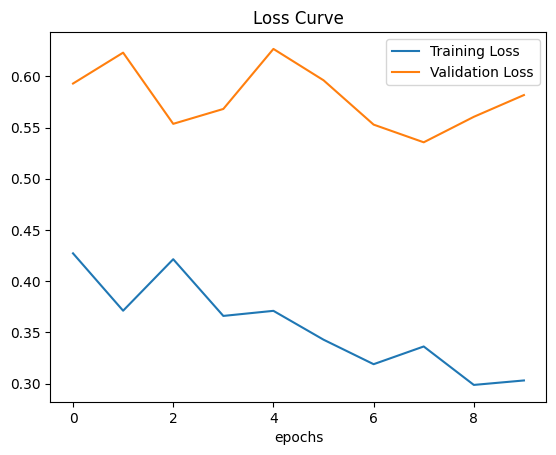

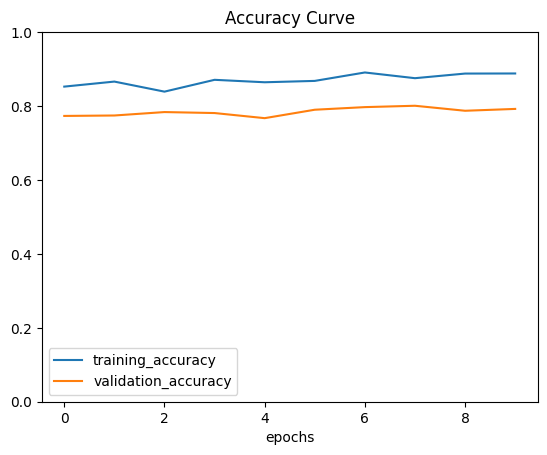

In [21]:
loss_and_accuracy(history = history_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


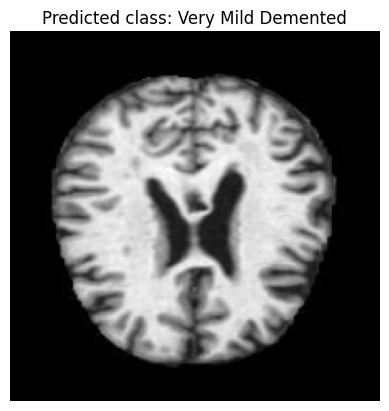

In [22]:
make_predictions(model_1 , '/content/OriginalDataset/VeryMildDemented/26 (45).jpg' , classnames )